# Phase 4 

## Topic 3 Image Classification with Deep Learning

## GOAL: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image

#### Build a deep neural network that trains on a large dataset for classification on a non-trivial task. In this case, using x-ray images of pediatric patients to identify whether or not they have pneumonia.

Aim for a Proof of Concept
With Deep Learning, data is king -- the more of it, the better. However, the goal of this project isn't to build the best model possible -- it's to demonstrate your understanding by building a model that works. You should try to avoid datasets and model architectures that won't run in reasonable time on your own machine. For many problems, this means downsampling your dataset and only training on a portion of it. Once you're absolutely sure that you've found the best possible architecture and other hyperparameters for your model, then consider training your model on your entire dataset overnight (or, as larger portion of the dataset that will still run in a feasible amount of time).

At the end of the day, we want to see your thought process as you iterate and improve on a model. A project that achieves a lower level of accuracy but has clearly iterated on the model and the problem until it found the best possible approach is more impressive than a model with high accuracy that did no iteration. We're not just interested in seeing you finish a model -- we want to see that you understand it, and can use this knowledge to try and make it even better!

Evaluation
Evaluation is fairly straightforward for this project. But you'll still need to think about which metric to use and about how best to cross-validate your results.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split



# Use Karas to import images and reshape them 

In [4]:
train_data_dir = 'chest_xray/train/'
val_data_dir = 'chest_xray/val/'
test_data_dir = 'chest_xray/test/'

In [40]:
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=624)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


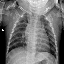

In [41]:
array_to_img(train_images[10])

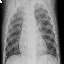

In [42]:
array_to_img(train_images[130])

In [43]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5216, 64, 64, 3)
(5216, 2)
(16, 64, 64, 3)
(16, 2)
(624, 64, 64, 3)
(624, 2)


##  `train_images`, `val_images` and `test_images`

In [66]:
# Reshape the train images 
train_img_unrow = train_images.reshape(5216, -1).T
np.shape(train_img_unrow)

(12288, 5216)

transform `val_images` 

In [67]:
# Reshape the val images 
val_img_unrow = val_images.reshape(16, -1).T

In [68]:
# Preview the shape of val_img_unrow
np.shape(val_img_unrow)

(12288, 16)

transform `test_images` in a similar way.

In [69]:
# Define appropriate m 
m = 624
test_img_unrow = test_images.reshape(m, -1).T

In [70]:
# Preview the shape of test_img_unrow
np.shape(test_img_unrow)

(12288, 624)

# `train_labels`, `val_labels` and `test_labels`

In [71]:
train_labels.shape,val_labels.shape, test_labels.shape

((5216, 2), (16, 2), (624, 2))

In [72]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [73]:
# this was stored using keras.preprocessing_image, and you can get more info using the command train_generator.class_indices
train_generator.class_indices, val_generator.class_indices, test_generator.class_indices

({'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1})

In [74]:
train_labels_final = train_labels.T[[1]]

In [75]:
np.shape(train_labels_final)

(1, 5216)

In [76]:
val_labels_final = val_labels.T[[1]]
np.shape(val_labels_final)

(1, 16)

In [77]:
test_labels_final = test_labels.T[[1]]

In [78]:
np.shape(test_labels_final)

(1, 624)

1. First, use array_to_image() again on the original train_images with index 240 to look at this particular image
2. Use train_labels_final to get the 240th label

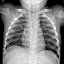

In [79]:
array_to_img(train_images[240])

In [80]:
train_labels_final[:,240]

array([0.], dtype=float32)

## Standardize the data

In [83]:
train_img_final = train_img_unrow/255
val_img_final = val_img_unrow/255
test_img_final = test_img_unrow/255

type(train_img_unrow)

numpy.ndarray

In [84]:
train_img_final.shape

(12288, 5216)

## Build a logistic regression-based neural network

   - Initialize the parameters of the model
   - Perform forward propagation, and calculate the current loss
   - Perform backward propagation (which is basically calculating the current gradient)
   - Update the parameters (gradient descent)

The cost function is then given by:
$$J(w,b) = \dfrac{1}{l}\displaystyle\sum^l_{i=1}\mathcal{L}(\hat y^{(i)}, y^{(i)})$$

$w$ and $b$ are the unknown parameters to start with: 
- remember that $b$ is a scalar
- $w$ however, is a vector of shape $n$ x $1$, with $n$ being `horizontal_pixel x vertical_pixel x 3`

# Baseline - Logistic Regression

Using gradient descent

#### Initialize b and w

In [85]:
b = 0

In [86]:
def init_w(n):
    w = np.zeros((n, 1))
    return w

In [87]:
w = init_w(64*64*3)

#### Forward Propagation

In [88]:
def propagation(w, b, x, y):
    l = x.shape[1]
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b)))                                  
    cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))    
    dw = (1/l) * np.dot(x,(y_hat - y).T)
    db = (1/l) * np.sum(y_hat - y)
    return dw, db, cost

In [89]:
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [26]:
print(dw)

print(db)

print(cost)

[[-0.05592934]
 [-0.05592934]
 [-0.05592934]
 ...
 [-0.02948357]
 [-0.02948357]
 [-0.02948357]]
-0.2429064417177914
0.6931471805599453


#### Optimization

$$w := w - \alpha * dw$$
$$b := b - \alpha * db$$

In [92]:
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

#### Predictions

In [93]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1, l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b))) 
    p = y_hat
    
    for i in range(y_hat.shape[1]):
        if (y_hat[0,i] > 0.5): 
            y_prediction[0, i] = 1
        else:
            y_prediction[0, i] = 0
    return y_prediction

## Overall Model - Baseline

In [94]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {'costs': costs, 
              'y_pred_test': y_pred_test,  
              'y_pred_train' : y_pred_train,  
              'w' : w, 
              'b' : b, 
              'learning_rate' : learning_rate, 
              'num_iterations': num_iterations}
    
    return output

#### using train and val

In [95]:
output = model(train_img_final, train_labels_final, val_img_final, val_labels_final, 
               num_iterations=500, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 1.524936
Cost after iteration 100: 0.366605
Cost after iteration 150: 0.315837
Cost after iteration 200: 0.188673
Cost after iteration 250: 0.163189
Cost after iteration 300: 0.152914
Cost after iteration 350: 0.146681
Cost after iteration 400: 0.142254
Cost after iteration 450: 0.138774
train accuracy: 95.0536809815951 %
test accuracy: 87.5 %


In [ ]:
train_img_final.shape

In [96]:
output = model(train_img_final, train_labels_final, test_img_final, test_labels_final, 
               num_iterations=500, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 1.524936
Cost after iteration 100: 0.366605
Cost after iteration 150: 0.315837
Cost after iteration 200: 0.188673
Cost after iteration 250: 0.163189
Cost after iteration 300: 0.152914
Cost after iteration 350: 0.146681
Cost after iteration 400: 0.142254
Cost after iteration 450: 0.138774
train accuracy: 95.0536809815951 %
test accuracy: 76.6025641025641 %


In [31]:
output = model(train_img_final, train_labels_final, test_img_final, test_labels_final, 
               num_iterations=500, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.497045
Cost after iteration 100: 0.326489
Cost after iteration 150: 0.242337
Cost after iteration 200: 0.223689
Cost after iteration 250: 0.209860
Cost after iteration 300: 0.199025
Cost after iteration 350: 0.190259
Cost after iteration 400: 0.182993
Cost after iteration 450: 0.176855
train accuracy: 94.28680981595092 %
test accuracy: 81.25 %


# MLP

In [ ]:
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [ ]:
train_images_mlp = (train_images / 255).astype('float32')
val_images_mlp = (val_images / 255).astype('float32')

In [ ]:
print(X_train.shape)
X_test.shape

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(64, 64, 3),
                        data_format = 'channels_last'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_1.add(layers.Flatten())        
model_1.add(layers.Dense(128))
model_1.add(layers.Activation('relu'))
#model_1.add(layers.Dropout(0.25))
model_1.add(layers.Dense(2))
model_1.add(layers.Activation('sigmoid'))

In [ ]:
model_1.summary()

In [ ]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_1.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

In [ ]:
val_loss, val_acc = model_1.evaluate(val_images_mlp, val_labels)

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(64, 64, 3),
                        data_format = 'channels_last'))
model_2.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_2.add(layers.Flatten())        
model_2.add(layers.Dense(512))
model_2.add(layers.Activation('relu'))
#model_1.add(layers.Dropout(0.25))
model_2.add(layers.Dense(2))
model_2.add(layers.Activation('sigmoid'))
model_2.summary()

In [ ]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_2.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

In [ ]:
val_loss, val_acc = model_2.evaluate(val_images_mlp, val_labels)

In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(64, 64, 3),
                        data_format = 'channels_last'))
model_3.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_3.add(layers.Flatten())        
model_3.add(layers.Dense(4096))
model_3.add(layers.Activation('relu'))
#model_1.add(layers.Dropout(0.25))
model_3.add(layers.Dense(2))
model_3.add(layers.Activation('sigmoid'))
model_3.summary()

In [ ]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_3.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

In [ ]:
val_loss, val_acc = model_2.evaluate(val_images_mlp, val_labels)

# More Pixels!

In [ ]:
more_pixels = 224, 224

In [ ]:
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(more_pixels), batch_size=16)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(more_pixels), batch_size=5216)

test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(more_pixels), batch_size=624)

test_images, test_labels = next(test_generator)
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [ ]:
train_images_mlp = (train_images / 255).astype('float32')
val_images_mlp = (val_images / 255).astype('float32')
test_images_mlp = (test_images / 255).astype('float32')

In [ ]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(224, 224, 3),
                        data_format = 'channels_last'))
model_4.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_4.add(layers.Flatten())        
model_4.add(layers.Dense(128))
model_4.add(layers.Activation('relu'))
#model_1.add(layers.Dropout(0.25))
model_4.add(layers.Dense(2))
model_4.add(layers.Activation('sigmoid'))

In [ ]:
model_4.summary()

In [ ]:
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['Recall'])
model_4.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

In [ ]:
val_loss, val_acc = model_4.evaluate(val_images_mlp, val_labels)

In [ ]:
test_loss, test_acc = model_4.evaluate(test_images_mlp, test_labels)